In [177]:
import librosa as li
import os
from glob import glob
import json
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch.nn as nn

In [178]:
device = torch.device('cuda')

In [179]:
top_path = 'data/nsynth-test/'
files = glob(f'{os.path.abspath(top_path)}/**/*.wav', recursive=True)
filenames = [os.path.basename(f).removesuffix('.wav') for f in files]
with open(os.path.join(top_path, 'examples.json')) as f:
    meta = json.load(f)

In [180]:
class Norm(nn.Module):
    def __init__(self):
        super(Norm, self).__init__()
    def forward(self, x):
        return x/x.max()

In [181]:
import torchaudio.transforms as T
import torch.nn as nn
transform = nn.Sequential(
    T.MelSpectrogram(sample_rate=16000,n_mels=256,n_fft=2048,norm='slaney'),
    Norm()

).to(device)
inverse_transform = nn.Sequential(
    T.InverseMelScale(sample_rate=16000,n_mels=256,n_stft=2048 // 2 + 1,norm="slaney"),
    T.GriffinLim(n_fft=2048),
).to(device)

In [182]:
def getitem(idx: int, load_audio = True) -> tuple[torch.Tensor, float, str]:
    fname = files[idx]
    _fname = filenames[idx]
    if load_audio:
        audio, _ = li.load(fname, sr=16000, mono=True, duration=(2**15)/16000)
        audio = torch.from_numpy(audio).to(device)
        x = transform(audio)
    else: 
        x = None
        audio = None
    pitch = meta[_fname]['pitch']
    return {"x": x, "pitch": pitch, "fname": _fname, "audio" : audio}

In [183]:
found = 0
for i in range(4096):
    item = getitem(i,load_audio=False)
    if item['fname'] == 'flute_synthetic_000-053-127':
        found = i
        print(found)
        break

1217


In [184]:
item = getitem(found)
spec, pitch, fname, audio = item['x'],item['pitch'],item['fname'],item['audio']
recreated_audio = inverse_transform(spec)
spec.shape

torch.Size([256, 33])

tensor(1., device='cuda:0')

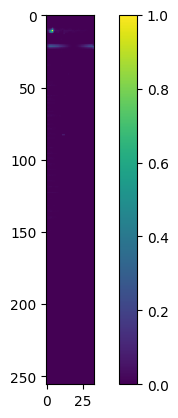

In [185]:
err = torch.abs(spec-img)
plt.imshow(err.cpu(),vmax=1)
plt.colorbar()
err.max()

In [186]:
display(Audio(inverse_transform(spec).cpu(),rate=16000))
display(Audio(inverse_transform(img).cpu(),rate=16000))

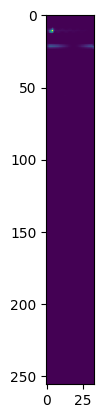

In [187]:
plt.imshow(spec.cpu())

In [188]:
display(Audio(audio.cpu(),rate=16000))
display(Audio(recreated_audio.cpu(),rate=16000))
audio.shape,recreated_audio.shape

(torch.Size([32768]), torch.Size([32768]))

In [189]:
print(spec.shape)
enc1=nn.Conv1d(in_channels=256,out_channels=256//2,kernel_size=3,stride=2,padding=1,device=device)(spec)
print(enc1.shape)
enc2=nn.Conv1d(in_channels=256//2,out_channels=256//4,kernel_size=3,stride=2,padding=1,device=device)(enc1)
print(enc2.shape)
enc3=nn.Conv1d(in_channels=256//4,out_channels=256//8,kernel_size=3,stride=2,padding=1,device=device)(enc2)
print(enc3.shape)


torch.Size([256, 33])
torch.Size([128, 17])
torch.Size([64, 9])
torch.Size([32, 5])


In [190]:
print(enc3.shape)
dec1 = nn.ConvTranspose1d(in_channels=256//8,out_channels=256//4,kernel_size=3,stride=2,padding=1,output_padding=0, device=device)(enc3)
print(dec1.shape)
dec2 = nn.ConvTranspose1d(in_channels=256//4,out_channels=256//2,kernel_size=3,stride=2,padding=1,output_padding=0,device=device)(enc2)
print(dec2.shape)
dec3 = nn.ConvTranspose1d(in_channels=256//2,out_channels=256,kernel_size=3,stride=2,padding=1,output_padding=0,device=device)(enc1)
print(dec3.shape)

torch.Size([32, 5])
torch.Size([64, 9])
torch.Size([128, 17])
torch.Size([256, 33])


In [192]:
import numpy as np

In [193]:
a=torch.Tensor([[1,2,3],[6,4,5]])
a/a.max(axis=1,keepdims=True).values

tensor([[0.3333, 0.6667, 1.0000],
        [1.0000, 0.6667, 0.8333]])

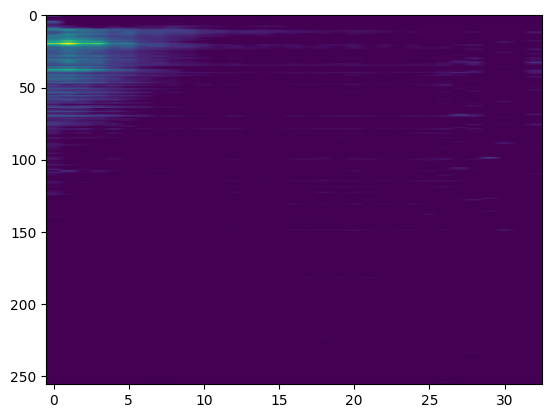

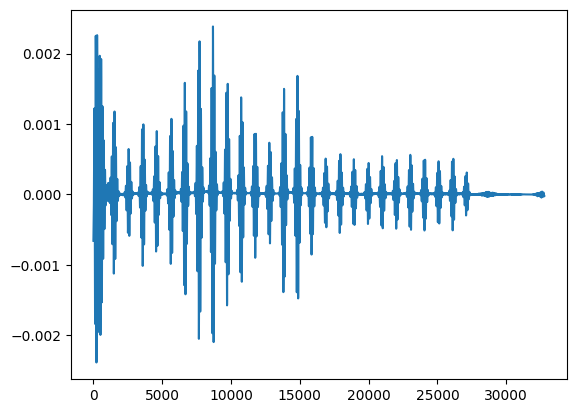

In [207]:
from PIL import Image
from torchvision import transforms as vT
img = Image.open("individualImage.png")
img = vT.ToTensor()(img)[0]
plt.imshow(img,aspect='auto')
plt.show()
img = img.to(device)
r_audio = inverse_transform(img).cpu()
plt.plot(r_audio)
display(Audio(r_audio,rate=16000))


In [201]:
from datetime import datetime
def find_most_recent_VAE():
    found_files = []
    for _, _, files in os.walk("results"):
        for file in files:
            if len(file)>4 and file[:4] == "VAE_":
                strdate = file[4:]
                date_object = datetime.strptime(strdate,"%d-%m-%Y_%H_%M")
                found_files.append(date_object)
    if found_files:
        found_date = (sorted(found_files)[-1]).strftime("%d-%m-%Y_%H_%M")
        most_recent_file = "VAE_"+found_date
        return most_recent_file
    else:
        raise Exception("No model found")

In [205]:
model = torch.load('results/'+find_most_recent_VAE())
with torch.no_grad():
    generated = model(spec[None,:,:])[0]
    plt.imshow(generated.cpu(),cmap="gray")
    plt.colorbar()
    plt.show()
    plt.imshow(spec.cpu(),cmap="gray")
    plt.colorbar()
    plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\lxqse\Documents\ATIAM\creative_ml\venv310\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\lxqse\AppData\Local\Temp\ipykernel_28504\2147587460.py", line 3, in <module>
    generated = model(spec[None,:,:])[0]
  File "c:\Users\lxqse\Documents\ATIAM\creative_ml\venv310\lib\site-packages\torch\nn\modules\module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\lxqse\Documents\ATIAM\creative_ml\venv310\lib\site-packages\torch\nn\modules\module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "c:\Users\lxqse\Documents\ATIAM\creative_ml\MultiEntVAE\src\VAE.py", line 120, in forward
    return x_tilde
  File "c:\Users\lxqse\Documents\ATIAM\creative_ml\MultiEntVAE\src\VAE.py", line 107, in encode
RuntimeError: shape '[-1, 9216]' is invalid for input of size 160

During 